In [2]:
# !unzip './content/Phase2.zip'

## Imports

In [3]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator

In [4]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_CLASSES = 3
CLASSES = ['Gaussian', 'Periodic', 'Salt']

In [5]:
base_dir = './content/DataSet2/Freq_Classification'
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')
val_dir = os.path.join(base_dir, 'Validation')

In [6]:
train_noise_dir = os.path.join(train_dir, 'With-Noise')
train_denoise_dir = os.path.join(train_dir, 'Without-Noise')
test_noise_dir = os.path.join(test_dir, 'With-Noise')
test_denoise_dir = os.path.join(test_dir, 'Without-Noise')
val_noise_dir = os.path.join(val_dir, 'With-Noise')
val_denoise_dir = os.path.join(val_dir, 'Without-Noise')

In [7]:
def get_files_count(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [8]:
num_classes=len(glob.glob(train_dir+"/With-Noise/*"))

train_samples =get_files_count(train_dir)
test_samples=get_files_count(test_dir)
val_samples=get_files_count(val_dir)

print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")
print(val_samples,"Val images")

0 Classes
0 Train images
0 Test images
0 Val images


**ImageDataGenerator**,Data augmentation is used to increase the size of training set. Through Data augmentation we want to prevent overfitting ,this refers to randomly changing the images in ways that shouldn’t impact their interpretation, such as horizontal flipping, zooming, and rotating
* **Rescale:** One of the many magnification parameters adjusts the pixel values of our image.
* **Shear_range:** counterclockwise shear angle in degrees
* **Zoom_range:** zoom
* **Horizontal_flip:** flip image horizontally

In [9]:
import cv2

# def convert_to_ms(image):
#     image = np.fft.fftshift(np.fft.fft2(image))
#     image = 20*np.log(np.abs(image))
#     return image

def convert_to_ms(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.fft.fftshift(np.fft.fft2(image))
    image = 20*(np.log(np.abs(image)))
    image = (image / np.max(image))*255
    image = cv2.cvtColor(np.uint8(np.round(image)), cv2.COLOR_GRAY2BGR)
    image = image/255
    return image

In [10]:
def read_images(folder_path):
    arr = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            arr.append(cv2.imread(file_path, cv2.IMREAD_GRAYSCALE))
    return np.array(arr)

In [11]:
data = pd.read_excel('./content/Labels.xlsx')
data.head()

,Denoise Image,Noise Type,Noisy Image
0,Without-Noise/cast_def_0_0.jpeg,Gaussian,With-Noise/cast_def_0_0.jpeg
1,Without-Noise/cast_def_0_2.jpeg,Gaussian,With-Noise/cast_def_0_2.jpeg
2,Without-Noise/cast_def_0_22.jpeg,Gaussian,With-Noise/cast_def_0_22.jpeg
3,Without-Noise/cast_def_0_25.jpeg,Gaussian,With-Noise/cast_def_0_25.jpeg
4,Without-Noise/cast_def_0_33.jpeg,Gaussian,With-Noise/cast_def_0_33.jpeg


In [12]:
from tensorflow.keras.utils import to_categorical

all_data = {'data': [convert_to_ms(cv2.imread(os.path.join(base_dir,file))) for file in data['Noisy Image']],
              'labels': [0 if t==CLASSES[0] else 1 if t==CLASSES[1] else 2 for t in data['Noise Type']]}
all_data


{'data': [array([[[0.22745098, 0.22745098, 0.22745098],
          [0.39607843, 0.39607843, 0.39607843],
          [0.40392157, 0.40392157, 0.40392157],
          ...,
          [0.43529412, 0.43529412, 0.43529412],
          [0.40392157, 0.40392157, 0.40392157],
          [0.39607843, 0.39607843, 0.39607843]],
  
         [[0.41960784, 0.41960784, 0.41960784],
          [0.44313725, 0.44313725, 0.44313725],
          [0.38431373, 0.38431373, 0.38431373],
          ...,
          [0.4       , 0.4       , 0.4       ],
          [0.40784314, 0.40784314, 0.40784314],
          [0.34117647, 0.34117647, 0.34117647]],
  
         [[0.40784314, 0.40784314, 0.40784314],
          [0.4       , 0.4       , 0.4       ],
          [0.42352941, 0.42352941, 0.42352941],
          ...,
          [0.42352941, 0.42352941, 0.42352941],
          [0.37647059, 0.37647059, 0.37647059],
          [0.43921569, 0.43921569, 0.43921569]],
  
         ...,
  
         [[0.42745098, 0.42745098, 0.42745098],
      

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_data['data'], all_data['labels'], test_size=0.2, random_state=100)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks for early stopping, model checkpointing, and learning rate reduction
my_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

## VGG16

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy



# Load pre-trained VGG16 model without the top layers
pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Freeze pre-trained layers for fine-tuning later
for layer in pretrained_model.layers:
    layer.trainable = False

x = pretrained_model.output
x = Flatten()(x)
# x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create full model
VGG16_model = Model(inputs=pretrained_model.input, outputs=predictions)

VGG16_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

VGG16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
history = 0
with tf.device('/GPU:0'):
    history = VGG16_model.fit(
        x = np.array(X_train),
        y = np.array(to_categorical(y_train)),
        steps_per_epoch=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(np.array(X_test), np.array(to_categorical(y_test))),
        # validation_steps=5,
        callbacks=my_callbacks
    )

Epoch 1/10
32/32 [==============================] - 29s 655ms/step - loss: 0.6111 - accuracy: 0.7230 - val_loss: 0.3092 - val_accuracy: 0.9040 - lr: 1.0000e-04
Epoch 2/10
32/32 [==============================] - 9s 296ms/step - loss: 0.2745 - accuracy: 0.9100 - val_loss: 0.3008 - val_accuracy: 0.8840 - lr: 1.0000e-04
Epoch 3/10
32/32 [==============================] - 11s 340ms/step - loss: 0.2259 - accuracy: 0.9180 - val_loss: 0.2418 - val_accuracy: 0.9240 - lr: 1.0000e-04
Epoch 4/10
32/32 [==============================] - 11s 343ms/step - loss: 0.1830 - accuracy: 0.9400 - val_loss: 0.2207 - val_accuracy: 0.9280 - lr: 1.0000e-04
Epoch 5/10
32/32 [==============================] - 11s 343ms/step - loss: 0.1801 - accuracy: 0.9380 - val_loss: 0.1952 - val_accuracy: 0.9320 - lr: 1.0000e-04
Epoch 6/10
32/32 [==============================] - 10s 299ms/step - loss: 0.1633 - accuracy: 0.9430 - val_loss: 0.1912 - val_accuracy: 0.9320 - lr: 1.0000e-04
Epoch 7/10
32/32 [=======================

In [17]:
predict = np.argmax(VGG16_model.predict(np.array(X_test)), axis=1)

8/8 [==============================] - 2s 235ms/step


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        76
           1       0.91      1.00      0.95        92
           2       0.95      1.00      0.98        82

    accuracy                           0.95       250
   macro avg       0.95      0.94      0.95       250
weighted avg       0.95      0.95      0.95       250



In [19]:
print("[INFO] Calculating model accuracy")
scores = VGG16_model.evaluate(np.array(X_test), np.array(to_categorical(y_test)))
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
8/8 [==============================] - 2s 233ms/step - loss: 0.1614 - accuracy: 0.9480
Test Accuracy: 94.80000138282776


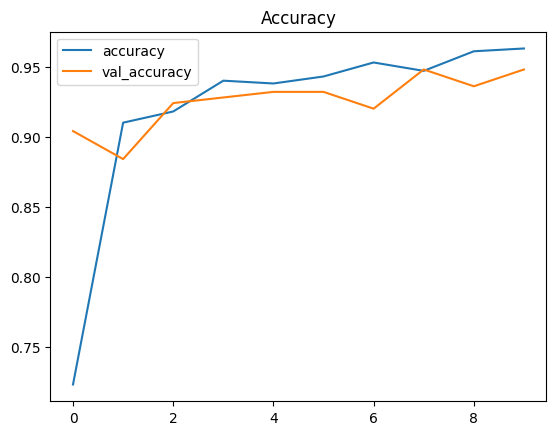

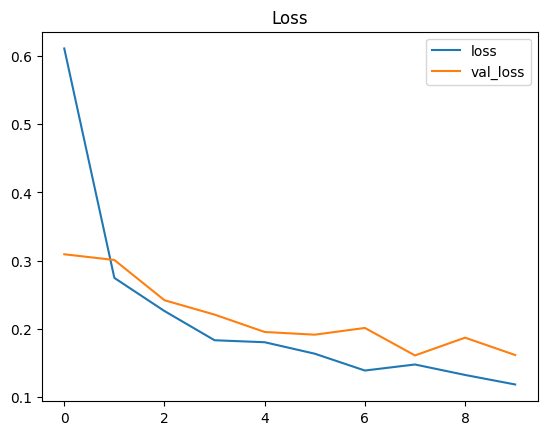

In [20]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [20]:
VGG16_model.save('./content/models/VGG16_Freq_Classification.h5')

## Inception ResNet V2

In [21]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions

pretrained_model = InceptionResNetV2(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [22]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

x = pretrained_model.output
x = Flatten()(x)
# x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)


IR_model = Model(inputs=pretrained_model.input, outputs=predictions)

IR_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [23]:
IR_model.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

In [24]:
history = 0
with tf.device('/GPU:0'):
    history = IR_model.fit(
        x = np.array(X_train),
        y = np.array(to_categorical(y_train)),
        # steps_per_epoch=32,
        epochs=EPOCHS,
        validation_data=(np.array(X_test), np.array(to_categorical(y_test))),
        # validation_steps=5,
        callbacks=my_callbacks
    )

Epoch 1/10
32/32 [==============================] - 26s 527ms/step - loss: 1.0174 - accuracy: 0.5200 - val_loss: 0.8728 - val_accuracy: 0.7560 - lr: 1.0000e-04
Epoch 2/10
32/32 [==============================] - 11s 340ms/step - loss: 0.7712 - accuracy: 0.8280 - val_loss: 0.7166 - val_accuracy: 0.8360 - lr: 1.0000e-04
Epoch 3/10
32/32 [==============================] - 11s 345ms/step - loss: 0.6534 - accuracy: 0.8640 - val_loss: 0.6329 - val_accuracy: 0.8720 - lr: 1.0000e-04
Epoch 4/10
32/32 [==============================] - 11s 337ms/step - loss: 0.5843 - accuracy: 0.9060 - val_loss: 0.5868 - val_accuracy: 0.8880 - lr: 1.0000e-04
Epoch 5/10
32/32 [==============================] - 11s 337ms/step - loss: 0.5474 - accuracy: 0.9150 - val_loss: 0.5592 - val_accuracy: 0.8840 - lr: 1.0000e-04
Epoch 6/10
32/32 [==============================] - 11s 337ms/step - loss: 0.5253 - accuracy: 0.9130 - val_loss: 0.5376 - val_accuracy: 0.8880 - lr: 1.0000e-04
Epoch 7/10
32/32 [======================

In [25]:
predict = np.int8(np.argmax(IR_model.predict(np.array(X_test)), axis=1))

8/8 [==============================] - 5s 284ms/step


In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82        89
           1       0.83      0.98      0.90        88
           2       0.90      0.99      0.94        73

    accuracy                           0.89       250
   macro avg       0.90      0.89      0.89       250
weighted avg       0.90      0.89      0.88       250



In [27]:
print("[INFO] Calculating model accuracy")
scores = IR_model.evaluate(np.array(X_test), np.array(to_categorical(y_test)))
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
8/8 [==============================] - 2s 265ms/step - loss: 0.5018 - accuracy: 0.8880
Test Accuracy: 88.80000114440918


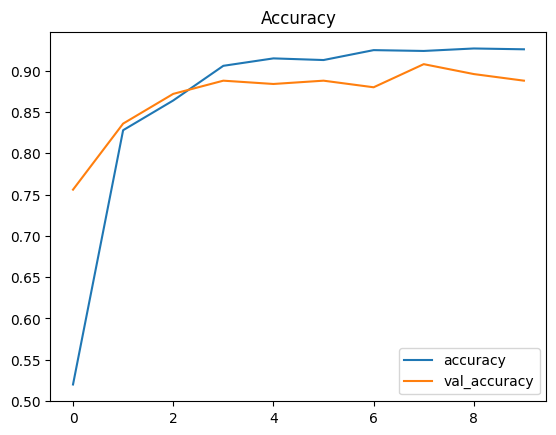

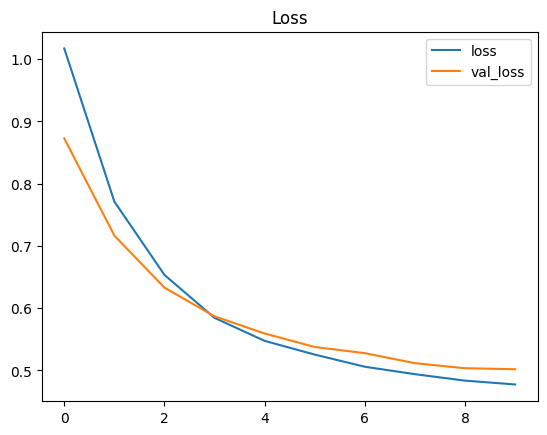

In [29]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [30]:
IR_model.save('./content/models/InceptionResNetV2_Freq_Classification.h5')

1/1 [==============================] - 4s 4s/step
Salt


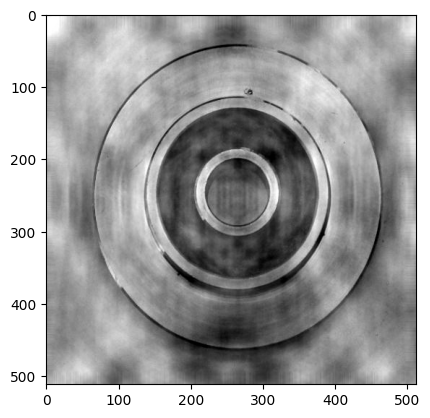

In [31]:
import keras.utils as image

def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

img_url='./content/DataSet2/Classification/Train/With-Noise/Periodic/cast_def_0_3185.jpeg'
result = IR_model.predict([prepare(img_url)])
casting_img=image.load_img(img_url)
plt.imshow(casting_img)

classresult=np.argmax(result,axis=1)
print(CLASSES[classresult[0]])

array([0.04313725, 0.05490196, 0.07843137, 0.09411765, 0.10196078,
       0.10588235, 0.10980392, 0.11372549, 0.11764706, 0.12156863,
       0.1254902 , 0.12941176, 0.13333333, 0.1372549 , 0.14117647,
       0.14509804, 0.14901961, 0.15294118, 0.15686275, 0.16078431,
       0.16470588, 0.16862745, 0.17254902, 0.17647059, 0.18039216,
       0.18431373, 0.18823529, 0.19215686, 0.19607843, 0.2       ,
       0.20392157, 0.20784314, 0.21176471, 0.21568627, 0.21960784,
       0.22352941, 0.22745098, 0.23137255, 0.23529412, 0.23921569,
       0.24313725, 0.24705882, 0.25098039, 0.25490196, 0.25882353,
       0.2627451 , 0.26666667, 0.27058824, 0.2745098 , 0.27843137,
       0.28235294, 0.28627451, 0.29019608, 0.29411765, 0.29803922,
       0.30196078, 0.30588235, 0.30980392, 0.31372549, 0.31764706,
       0.32156863, 0.3254902 , 0.32941176, 0.33333333, 0.3372549 ,
       0.34117647, 0.34509804, 0.34901961, 0.35294118, 0.35686275,
       0.36078431, 0.36470588, 0.36862745, 0.37254902, 0.37647

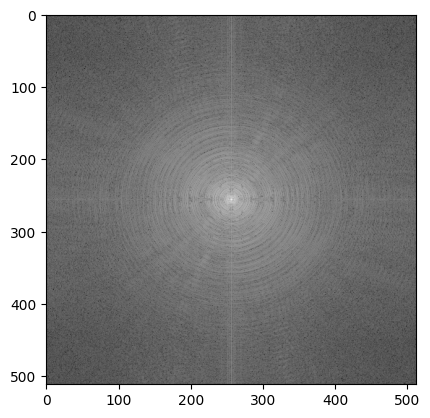

In [32]:
def convert_to_ms(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.fft.fftshift(np.fft.fft2(image))
    image = 20*np.log(np.abs(image))
    image = (image / np.max(image))*255
    image = cv2.cvtColor(np.uint8(np.round(image)), cv2.COLOR_GRAY2BGR)
    return image


img = cv2.imread('./content/DataSet2/Classification/Train/With-Noise/Periodic/cast_def_0_3185.jpeg')
plt.imshow(convert_to_ms(img))
np.unique(convert_to_ms(img)/255)